In [21]:
# Name: Marcus Tan
# Matric No.: A0149980N

SyntaxError: invalid syntax (<ipython-input-21-fb44940ecd7e>, line 1)

## Assignment 1: Anomaly Detection with Machine Learning

Anomaly detection is widely used in behavioral analysis to determine types of anomaly occurring in a given data set. It’s applicable in domains such as fraud detection, intrusion detection, fault detection and system health monitoring in sensor networks. 

<figure>
<center>
<img src="https://thedatascientist.com/wp-content/uploads/2019/02/anomaly_detection-1024x683.png"
     alt="anomaly detection"
     width="375" height="250"/>
</center>
</figure>

As anomalies are usually not predefined, and sicne its detection is highly dependent on historical data, machine learning is suitable for the task. The detection can be done in a supervised, semi-supervised and unsupervised manner.

For a supervised approach, we need to know whether each observation/item/event is anomalous or regular. However, it's often unrealistic to obtain labels for anomalies. And even after that, there would be a problem of imbalanced learning since the portion of anomalies is always much smaller.

A semi-supervised situation is where we only know which observations are regular, without information on the anomalies. In this case, the training objective is to find the similarity between a new data point to the training data which is all regular. Those who are least similar are considered anomalies.

For an unsupervised approach, we don't have any labels, which is the most common case. The objective is to find the anomalies whose features differ from the normal observations significantly.

### Task:
In this notebook, we will compare results for different ML algorithms in an anomaly detection task. 

You need to follow the steps below and complete code snippets:

1. Read the given example in section 2.1;
2. Complete the code in section 2.2 under instructions;
3. Use what you just learned from the 2 steps above, and complete section 2.3 on your own.
4. Use what you just learned from the NLP part to complete 2.4.

In [1]:
# Libraries
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

from warnings import simplefilter
simplefilter(action='ignore')

### 1. Data

"ambient_temperature_system_failure.csv": The hourly ambient temperature in an office (from July 14th 2013 to May 28th 2014), where anomalies are recorded. 

There are only 2 columns in the data: timestamp and the temperature value in Fahrenheit.

As timestamp will be used as index, there is actually only one dimension of data.

In [2]:
# Download data to a dataframe
df = pd.read_csv("temperature.csv")

Some basic EDA and plotting the original data:

In [3]:
# Change temperature to Celsius
df['value'] = (df['value'] - 32) * 5/9

df.head()

,timestamp,value
0,2013-07-04 00:00:00,21.044908
1,2013-07-04 01:00:00,21.789015
2,2013-07-04 02:00:00,21.598781
3,2013-07-04 03:00:00,20.533000
4,2013-07-04 04:00:00,20.713084


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
value,7267.0,21.801352,2.359727,14.143559,20.205228,22.143607,23.572754,30.124007


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


As timestamp is string, we need to change it to epochtime later for easier processing and plotting.

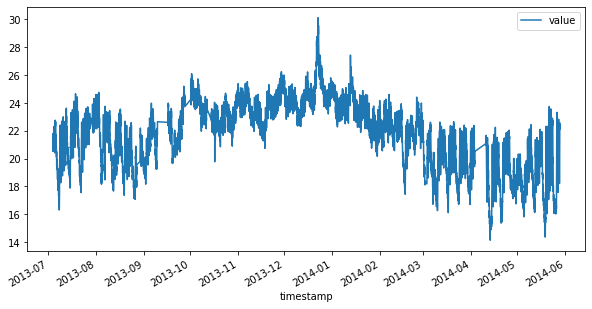

In [6]:
# Plot the original data

# Change datetime to epoch time (int) for data processing & modelling later
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['time_epoch'] = df['timestamp'].astype(np.int64) // 100000000000
df.plot(x='timestamp', y='value', figsize=(10,5))

From the original plotting we can see some sudden spikes and dips, which denote anomalous. 

Please note that we use this dataset as an example for you to spot anomalies easily. In real life, with more columns as features (high dimensional), we cannot visualize anymore, let alone find anomalies just with our eyes.

### 2. Models

#### 2.1 Clustering

A simple clustering on the data. When grouping features, data points that are far away from the centroids are detected as anomalies. We use [k-means](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html) as an example.

<font color=green>Note:</font> Section 2.1 is an example where you don't need to input any code.

In [7]:
# Return a series of distances between each data point and the closest centroid
def getDistance(data, model):
    distance = pd.Series()
    for i in range(len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

In [8]:
# Standardize the data
data = df[['value', 'time_epoch']]
scaled = StandardScaler().fit_transform(data)
data = pd.DataFrame(scaled)

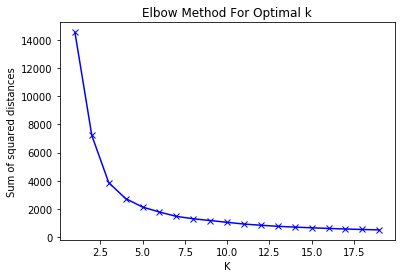

In [9]:
# Plot to find optimal k (elbow method)
Sum_of_squared_distances = []
km_models = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters=k).fit(data)
    km_models.append(km)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

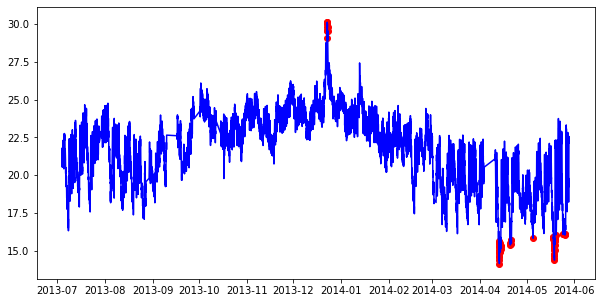

In [10]:
# Anomly population estimated to: 1%
# You can set to different values to view different results
anomaly_fraction = 0.01

# Choose k=3
# You can set to different values to view different results
distances = getDistance(data, km_models[2])
number_of_anomalies = int(anomaly_fraction*len(data))

# Farrest points are considered anomalies
threshold = distances.nlargest(number_of_anomalies).min()
df['anomaly'] = (distances >= threshold).astype(int)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
a = df.loc[df['anomaly'] == 1, ['timestamp', 'value']]
ax.plot(df['timestamp'], df['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

As you can see, some spikes are detected as anomalies.

#### 2.2 Isolation Forest

[Isolation Forest](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf) can be understood as an unsupervised random forest algorithm. We start by building multiple decision trees such that the trees isolate the observations in their leaves. Ideally, each leaf of the tree isolates exactly one observation from our dataset. The trees are being split randomly. We assume that if one observation is similar to others in our data set, it will take **more random splits** to perfectly isolate this observation, as opposed to isolating an anomaly.

Since we have multiple decision trees, hence the isolation forest, we can calculate the average number of splits across all the trees that isolate the observation. The average number of splits is then used as a score, where the less splits the observation needs, the more likely it is to be anomalous.

In [11]:
df.shape

(7267, 4)

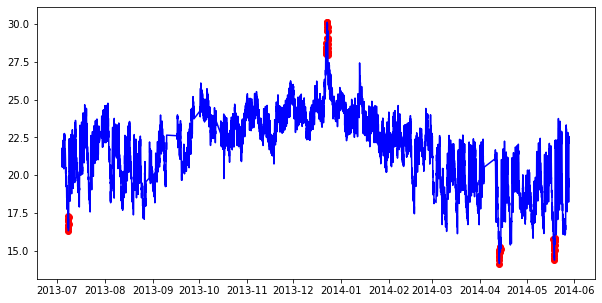

In [12]:
# Standardize the data
data = df[['value', 'time_epoch']]
scaled = StandardScaler().fit_transform(data)
data = pd.DataFrame(scaled)

# Train isolation forest
anomaly_fraction = 0.01
######################################################################
# ToDo:
# 1. Train the iForest model (sklearn.ensemble.IsolationForest) with 
# standardized data;
clf = IsolationForest(n_estimators=50, max_samples='auto', contamination=float(anomaly_fraction),max_features=1.0)
clf.fit(data)
# 2. Calculate the prediction to df['anomaly'].
df['anomaly'] = clf.predict(data)
######################################################################

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
######################################################################
# ToDo:
# 3. Make a subset dataframe "a" of timestamp and anomaly values for 
# plotting.
a = df.loc[df['anomaly'] == -1, ['timestamp', 'value']]
######################################################################
ax.plot(df['timestamp'], df['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

#### 2.3 OCSVM

OCSVM (One-Class Support Vector Machine) is used for unsupervised outlier detection, implemented based on libsvm. It requires the choice of a kernel and a scalar parameter to define a frontier. The RBF kernel is usually chosen although there exists no exact formula or algorithm to set its bandwidth parameter. This is the default in the scikit-learn implementation.

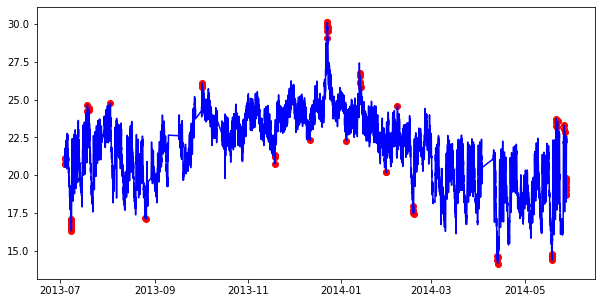

In [13]:
######################################################################
# ToDo:
# 1. Standardize the data if you think necessary;
data = df[['value', 'time_epoch']]
scaled = StandardScaler().fit_transform(data)
data_scaled = pd.DataFrame(scaled)
# 2. Train the OC SVM model (sklearn.svm.OneClassSVM) and get anomaly 
# prediction;
anomaly_fraction = 0.01
ocsvm = OneClassSVM(gamma='auto',nu=anomaly_fraction)
ocsvm.fit(data_scaled)
df['anomaly'] = ocsvm.predict(data_scaled)
# 3. Plot for comparison with above.
fig, ax = plt.subplots(figsize=(10, 5))
a = df.loc[df['anomaly'] == -1, ['timestamp', 'value']]
ax.plot(df['timestamp'], df['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()
######################################################################

#### 2.4 RNN

RNN (Recurrent Neural Network) is good at recognizing sequences in data and can make predictions based on previous sequences. In anomaly detection, we define an anomaly when the next prediction is distant from RNN's prediction.

We will use LSTM (Long Short-Term Memory) in this example for its capability of memorizing older information from a sequence.

<font color=green>Note:</font> For this method, we assume that there's no anomaly in the training data.

In [14]:
# Import libraries for RNN
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [15]:
# Creates sequences and their next one points as the prediction targets
def sequencize(data, time_step=10):
    # eg:
    # in:   data=[1,2,3,4,5,6];            time_step=3
    # out:  x=[[1,2,3], [2,3,4], [3,4,5]]; y=[4,5,6]
    x, y = [], []
    for i in range(len(data)):
        end_ix = i + time_step
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.asarray(x), np.asarray(y)

In [16]:
# Standardize the data
# For RNN based time series prediction, we don't need an explicit 'time_epoch' column
data = df[['value']]
scaled = StandardScaler().fit_transform(data)

# Parameters
prediction_time = 1     # predict only the next 1 point
seq_len = 30            # use 30 previous points to predict the next one
anomaly_fraction = 0.01
test_size = 1000

# Make sequences and their prediction targets
# y is the next value of the sequence x
# In another word: y(t) is the last value of the next sequence x(t+1). We can use this to test our data integrity
# Test: x[t+1][seq_len-1][0] == y[t]
test = scaled[-test_size-seq_len:]
train = scaled[:len(scaled)-test_size-seq_len]
x_train, y_train = sequencize(train, time_step=30)
x_test, y_test = sequencize(test, time_step=30)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6207, 30, 1)
y_train (6207, 1)
x_test (1000, 30, 1)
y_test (1000, 1)


A good article on LSTM based time series prediction: [here](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/) for reference.

In [17]:
######################################################################
# ToDo:
# 1. Build the LSTM model (you can refer to the article above);
# 2. Train the model with preprecessed data provided above;
# 3. Predict on test data and calculate anomalies accordingly;
# 4. Plot for comparison.
######################################################################

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(30,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

n_features = 1
X = x_train
X = x_train.reshape((X.shape[0], X.shape[1], n_features))
y = y_train
model.fit(X,y, epochs=200, verbose=1)

Epoch 1/200
194/194 [==============================] - 2s 7ms/step - loss: 0.2082
Epoch 2/200
194/194 [==============================] - 1s 6ms/step - loss: 0.0719
Epoch 3/200
194/194 [==============================] - 1s 6ms/step - loss: 0.0531
Epoch 4/200
194/194 [==============================] - 1s 7ms/step - loss: 0.0415
Epoch 5/200
194/194 [==============================] - 1s 6ms/step - loss: 0.0406
Epoch 6/200
194/194 [==============================] - 1s 6ms/step - loss: 0.0395
Epoch 7/200
194/194 [==============================] - 1s 6ms/step - loss: 0.0387
Epoch 8/200
194/194 [==============================] - 1s 6ms/step - loss: 0.0380
Epoch 9/200
194/194 [==============================] - 1s 6ms/step - loss: 0.0376
Epoch 10/200
194/194 [==============================] - 1s 6ms/step - loss: 0.0372
Epoch 11/200
194/194 [==============================] - 1s 6ms/step - loss: 0.0378
Epoch 12/200
194/194 [==============================] - 1s 6ms/step - loss: 0.0368
Epoch 13/200


194/194 [==============================] - 1s 6ms/step - loss: 0.0320
Epoch 197/200
194/194 [==============================] - 1s 7ms/step - loss: 0.0321
Epoch 198/200
194/194 [==============================] - 1s 7ms/step - loss: 0.0321
Epoch 199/200
194/194 [==============================] - 1s 6ms/step - loss: 0.0322
Epoch 200/200
194/194 [==============================] - 1s 7ms/step - loss: 0.0319


In [18]:
XT = x_test
XT = XT.reshape((XT.shape[0], XT.shape[1], n_features))
yhat = model.predict(XT, verbose=1)

32/32 [==============================] - 0s 2ms/step


In [19]:
indexes = [i for i in range(1000)]
indexes = df['timestamp'][-1000:]

7267


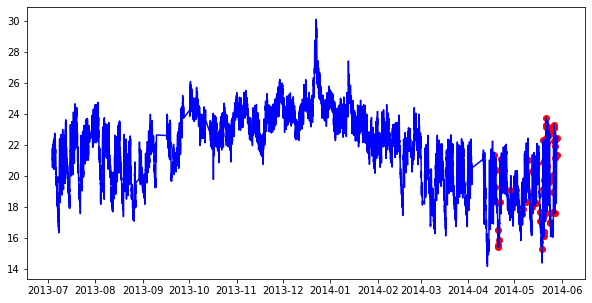

In [20]:
print(len(scaled))

fig, ax = plt.subplots(figsize=(10, 5))
diff = yhat - y_test
second_indexes = []
vals = []
one_percent = anomaly_fraction * len(df['timestamp'])
rounded_percent = round(one_percent)
a = []

for i in range(1000):
    a.append([abs(diff[i][0]), y_test[i] ,df['timestamp'][6267+i], df['value'][6267+i]])

a = sorted(a)

a = a[-rounded_percent:];

b = [a[i][3] for i in range(rounded_percent)] # vals
c = [a[i][2] for i in range(rounded_percent)] # timestamps

# plot the anamomalies 
ax.plot(df['timestamp'], df['value'], color='blue')
ax.scatter(c, b, color='red')
plt.show()

From the above results, what do you observe? Which algorithm do you think is the best? (This question will not be scored, feel free to share your observation and understanding)

<span style="color:blue">--- Your answer here ---</span>
I would say that One-Class Support Vector Machine is the best because anomalies detected looked rather spread out and looks like the extreme points on the graph.

Related Reading:

[1]. [Novelty and Outlier Detection](https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection)

[2]. [Comparing anomaly detection algorithms for outlier detection on toy datasets](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html?highlight=anomaly)

[3]. [Timeseries anomaly detection using an Autoencoder](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)

[4]. [How to Evaluate the Quality of Unsupervised Anomaly Detection Algorithms?](https://arxiv.org/pdf/1607.01152.pdf)